In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import torch.optim as optim
import random
from PIL import Image
# from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

%matplotlib inline


In [2]:
project_name='rock-paper-scissors'

In [3]:
    
# Look into the data directory
data_dir = './datasets/Datasets/Datasets'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

# data_dir = "./archive"
# print(os.listdir(data_dir))
# classes = os.listdir(data_dir + "/Rock-Paper-Scissors/train")
# print(classes)

['test', 'train', 'val']
['paper', 'rock', 'scissors']


In [4]:
#Working for common images
# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#Working for normal white images
#stats = ((0.8763, 0.8430, 0.8365), (0.2030, 0.2536, 0.2634))

#For complex with face images
# stats = ((0.3754, 0.3303, 0.3217), (0.2652, 0.2442, 0.2305))

stats=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# stats=((-0.8244, -1.0126, -0.7527)), ((1.2136, 1.1163, 1.0315))


train_tfms = tt.Compose([tt.CenterCrop(224),
                         tt.Resize((32,32)), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize((32,32)),tt.ToTensor(), tt.Normalize(*stats)])


In [ ]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
test_ds = ImageFolder(data_dir+'/test', valid_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

print(len(test_ds))


In [5]:
batch_size = 64;

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
# def accuracy(outputs, labels):
#     _, preds = torch.max(outputs, dim=1)
#     return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# class ImageClassificationBase(nn.Module):
#     def training_step(self, batch):
#         images, labels = batch 
#         out = self(images)                  # Generate predictions
#         loss = F.cross_entropy(out, labels) # Calculate loss
#         return loss
    
#     def validation_step(self, batch):
#         images, labels = batch 
#         out = self(images)                    # Generate predictions
#         loss = F.cross_entropy(out, labels)   # Calculate loss
#         acc = accuracy(out, labels)           # Calculate accuracy
#         return {'val_loss': loss.detach(), 'val_acc': acc}
        
#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
#         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
#             epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
# def conv_block(in_channels, out_channels, pool=False):
#     layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
#               nn.BatchNorm2d(out_channels), 
#               nn.ReLU(inplace=True)]
#     if pool: layers.append(nn.MaxPool2d(2))
#     return nn.Sequential(*layers)

# class ResNet9(ImageClassificationBase):
#     def __init__(self, in_channels, num_classes):
#         super().__init__()
        
#         self.conv1 = conv_block(in_channels, 64)
#         self.conv2 = conv_block(64, 128, pool=True)
#         self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
#         self.conv3 = conv_block(128, 256, pool=True)
#         self.conv4 = conv_block(256, 512, pool=True)
#         self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
#         self.classifier = nn.Sequential(nn.MaxPool2d(4), 
#                                         nn.Flatten(), 
#                                         nn.Linear(512, num_classes))
        
#     def forward(self, xb):
#         out = self.conv1(xb)
#         out = self.conv2(out)
#         out = self.res1(out)
#         out = self.conv3(out)
#         out = self.conv4(out)
#         out = self.res2(out)
#         out = self.classifier(out)
#         return out

In [ ]:
# model = to_device(ResNet9(3, 3), device)

In [ ]:
# @torch.no_grad()
# def evaluate(model, val_loader):
#     model.eval()
#     outputs = [model.validation_step(batch) for batch in val_loader]
#     return model.validation_epoch_end(outputs)

# def get_lr(optimizer):
#     for param_group in optimizer.param_groups:
#         return param_group['lr']

# def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
#                   weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
#     torch.cuda.empty_cache()
#     history = []
    
#     # Set up cutom optimizer with weight decay
#     optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
#     # Set up one-cycle learning rate scheduler
#     sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
#                                                 steps_per_epoch=len(train_loader))
    
#     for epoch in range(epochs):
#         # Training Phase 
#         model.train()
#         train_losses = []
#         lrs = []
#         for batch in train_loader:
#             loss = model.training_step(batch)
#             train_losses.append(loss)
#             loss.backward()
            
#             # Gradient clipping
#             if grad_clip: 
#                 nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
#             optimizer.step()
#             optimizer.zero_grad()
            
#             # Record & update learning rate
#             lrs.append(get_lr(optimizer))
#             sched.step()
        
#         # Validation phase
#         result = evaluate(model, val_loader)
#         result['train_loss'] = torch.stack(train_losses).mean().item()
#         result['lrs'] = lrs
#         model.epoch_end(epoch, result)
#         history.append(result)
#     return history

In [ ]:
# history = [evaluate(model, valid_dl)]
# history

In [ ]:
# epochs = 8
# max_lr = 0.01
# grad_clip = 0.1
# weight_decay = 1e-4
# opt_func = torch.optim.Adam

In [ ]:
# %%time
# history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
#                              grad_clip=grad_clip, 
#                              weight_decay=weight_decay, 
#                              opt_func=opt_func)

In [ ]:
# Define the ResNet9 model
class ResNet9(nn.Module):
    def __init__(self):
        super(ResNet9, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
class SmallResNet9(nn.Module):
    def __init__(self, num_classes=3):
        super(SmallResNet9, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(256, num_classes)
        
        self.fc = nn.Sequential(nn.MaxPool2d(4), 
                      nn.Flatten(), 
                      nn.Dropout(0.2),
                      nn.Linear(256, num_classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [9]:
model = to_device(SmallResNet9(),device)

In [10]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

In [ ]:
# # Define training function with k-fold cross-validation
# def train_k_fold(model, dataloader, num_epochs, learning_rate, k):
#     # Define device (use GPU if available)
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     # Define loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     # Initialize lists for tracking training loss and accuracy
#     train_loss = []
#     train_acc = []

#     # Perform k-fold cross-validation
#     for fold, (train_indices, val_indices) in enumerate(kf.split(dataloader)):
#         print(f'Fold {fold+1}')

#         # Split data into training and validation sets
#         train_data = torch.utils.data.Subset(dataloader.dataset, train_indices)
#         val_data = torch.utils.data.Subset(dataloader.dataset, val_indices)

#         train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
#         val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

#         # Move model to device
#         model.to(device)

#         # Train model for specified number of epochs
#         for epoch in range(num_epochs):
#             # Train model on training set
#             model.train()
#             train_loss.append(train(model, train_loader, criterion, optimizer))

#             # Calculate accuracy on training set
#             correct = 0
#             total = 0
#             with torch.no_grad():
#                 for inputs, labels in train_loader:
#                     inputs = inputs.to(device)
#                     labels = labels.to(device)

#                     outputs = model(inputs)
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#             train_acc.append(correct / total)

#             # Calculate accuracy on validation set
#             correct = 0
#             total = 0
#             with torch.no_grad():
#                 for inputs, labels in val_loader:
#                     inputs = inputs.to(device)
#                     labels = labels.to(device)

#                     outputs = model(inputs)
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#             val_acc = correct / total
#             print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import ToTensor, Normalize, Compose
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define dataset and dataloader
transform = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = ImageFolder('./datasets/Datasets/Datasets/train', train_tfms)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
dataloader = DeviceDataLoader(dataloader, device)

# Define k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True)

# Define training loop function
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

# Define evaluation function
def evaluate(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Initialize lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

# Train and validate for each fold
for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
    print(f'Fold {fold + 1}/{k}')
    
    # Create subset datasets and dataloaders for this fold
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
    

    
    # Define model, optimizer, and criterion
    model = SmallResNet9()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Train and validate for this fold
    for epoch in range(30):
        train_loss = train(model, train_loader, criterion, optimizer)
#         val_loss = evaluate(model, val_loader)
        val_loss = train(model,val_loader,criterion,optimizer)
        val_accuracy = evaluate(model, val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Epoch {epoch + 1} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f} - Val accuracy: {val_accuracy:.4f}')
    
    # Save the model for this fold
    torch.save(model.state_dict(), f'resnet9_fold{fold}.pt')
    
# Print overall validation accuracy
print(f'Overall validation accuracy: {np.mean(val_accuracies):.4f}')


Fold 1/5
Epoch 1 - Train loss: 0.4202 - Val loss: 2.3240 - Val accuracy: 0.3150
Epoch 2 - Train loss: 1.1429 - Val loss: 1.7659 - Val accuracy: 0.3386
Epoch 3 - Train loss: 0.9490 - Val loss: 1.7537 - Val accuracy: 0.3403
Epoch 4 - Train loss: 0.9224 - Val loss: 1.8137 - Val accuracy: 0.4494
Epoch 5 - Train loss: 0.8101 - Val loss: 1.8961 - Val accuracy: 0.3499
Epoch 6 - Train loss: 0.7536 - Val loss: 1.8698 - Val accuracy: 0.3342
Epoch 7 - Train loss: 0.9711 - Val loss: 1.7227 - Val accuracy: 0.3709
Epoch 8 - Train loss: 0.6134 - Val loss: 1.7181 - Val accuracy: 0.4424
Epoch 9 - Train loss: 0.8182 - Val loss: 1.9681 - Val accuracy: 0.3700
Epoch 10 - Train loss: 0.7356 - Val loss: 1.7100 - Val accuracy: 0.3647
Epoch 11 - Train loss: 0.6308 - Val loss: 1.8003 - Val accuracy: 0.4380
Epoch 12 - Train loss: 0.4990 - Val loss: 1.8214 - Val accuracy: 0.6370
Epoch 13 - Train loss: 0.4409 - Val loss: 1.6646 - Val accuracy: 0.4729
Epoch 14 - Train loss: 0.4317 - Val loss: 1.5578 - Val accuracy:

Epoch 25 - Train loss: 0.0750 - Val loss: 0.2265 - Val accuracy: 0.9624
Epoch 26 - Train loss: 0.0637 - Val loss: 0.1722 - Val accuracy: 0.9686
Epoch 27 - Train loss: 0.0646 - Val loss: 0.1943 - Val accuracy: 0.9721
Epoch 28 - Train loss: 0.0466 - Val loss: 0.1188 - Val accuracy: 0.9677
Epoch 29 - Train loss: 0.0490 - Val loss: 0.0842 - Val accuracy: 0.9729
Epoch 30 - Train loss: 0.0393 - Val loss: 0.0532 - Val accuracy: 0.9520
Fold 5/5
Epoch 1 - Train loss: 0.4032 - Val loss: 2.5745 - Val accuracy: 0.3258
Epoch 2 - Train loss: 0.9740 - Val loss: 2.0635 - Val accuracy: 0.3380
Epoch 3 - Train loss: 0.8409 - Val loss: 1.8124 - Val accuracy: 0.4803
Epoch 4 - Train loss: 0.6332 - Val loss: 1.6885 - Val accuracy: 0.5109
Epoch 5 - Train loss: 0.5307 - Val loss: 1.7410 - Val accuracy: 0.5476
Epoch 6 - Train loss: 0.4467 - Val loss: 1.6569 - Val accuracy: 0.3983
Epoch 7 - Train loss: 0.4595 - Val loss: 1.7319 - Val accuracy: 0.6052
Epoch 8 - Train loss: 0.4743 - Val loss: 1.4838 - Val accuracy

In [ ]:
torch.save(model, './saved_model.pth')

In [14]:
def plot_losses():
#     train_losses = [x.get('train_loss') for x in history]
#     val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

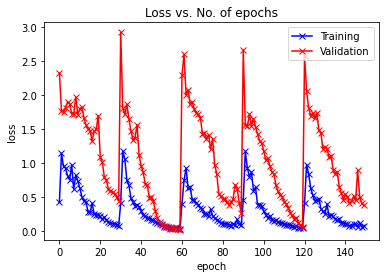

In [15]:
plot_losses()